### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import PIL
import re
import tensorflow as tf 


In [2]:
from matplotlib import patheffects as pe
from mpl_toolkits.axes_grid1 import ImageGrid
from tensorflow import keras

In [3]:
tf.compat.v1.disable_eager_execution()

### Global Parameters

In [4]:
EPOCHS = 30
IMAGE_SIZE = (224, 224)
PKMN_DIRECTORY = 'C:/temp/PokemonData'
PLOT_DIRECTORY = 'Plots'
TEST_SIZE = 1000
TRAIN_SIZE = 6000
CLASS_COUNT = len(os.listdir(PKMN_DIRECTORY + '/Train'))

### Data

#### Data Generator Initialization

In [5]:
# Define ImageDataGenerator with custom augmentation parameters.
image_data_generator = keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip = True, height_shift_range = 0.05, width_shift_range = 0.05,
    zoom_range = 0.2, brightness_range = [0.9, 1.5], rescale = 1./255.)

# Initialize flow from training data directory.
train_flow = image_data_generator.flow_from_directory(PKMN_DIRECTORY + '/Train',
    target_size = IMAGE_SIZE, batch_size = 64)

# Set up flow from test data directory.
test_flow = image_data_generator.flow_from_directory(PKMN_DIRECTORY + '/Test', 
    target_size = IMAGE_SIZE, batch_size = 64)

Found 3421 images belonging to 149 classes.
Found 3358 images belonging to 149 classes.


#### Data Set Generation

In [6]:
def generate_data_set(size, generator):
    """
    Accept a keras ImageDataGenerator flow and use it to generate X and Y numpy 
    arrays of a specified size.
    
    Args:
        size: The amount of images and labels to generate.
        generator: ImageDataGenerator flow.
    Returns:
        X: "size" images from generator.
        Y: "size" labels from generator.
    """
    # Initialize loop variables.
    X = []
    Y = []

    while len(X) < size:
        next_images, next_labels = test_flow.next()
        X.extend(next_images)
        Y.extend(next_labels)

    # Cut off any extra unwanted images.
    X = X[:size]
    Y = Y[:size]

    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

In [7]:
X_train, Y_train = generate_data_set(TRAIN_SIZE, train_flow)
X_test, Y_test = generate_data_set(TEST_SIZE, test_flow)

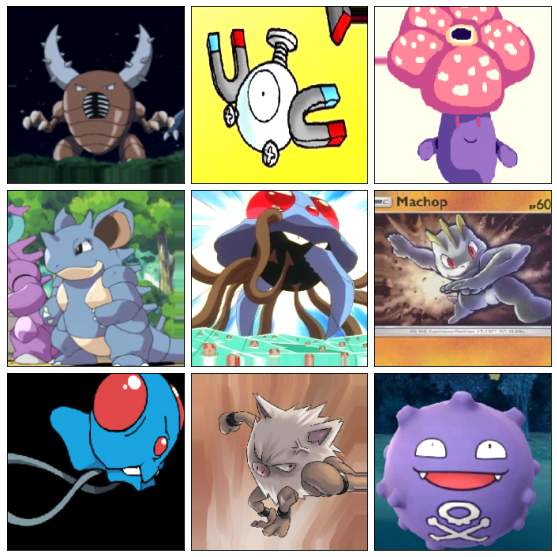

In [8]:
# Initialize plot.
fig = plt.figure(1, (10, 10))
grid = ImageGrid(fig, 111, nrows_ncols = (3, 3), axes_pad = 0.1)

for ax, image in zip(grid, X_test):
    # Reverse normalization to get full pixel values.
    image = np.array(image * 255).astype('uint8')
    # Show image in grid cell.
    ax.imshow(image)
    # Remove ticks from around image.
    ax.tick_params(axis = 'both', which = 'both', bottom = False, left = False,
        labelbottom = False, labelleft = False)

fig.savefig(PLOT_DIRECTORY + '/data_example.jpg', bbox_inches = 'tight')

### Scratch-Built Model

#### Model Structure

In [9]:
# Initialize model.
scratch_model = keras.models.Sequential()
# Convolutional Layers
scratch_model.add(keras.layers.Conv2D(16, (3, 3), activation = 'relu', 
    input_shape = (*IMAGE_SIZE, 3)))
scratch_model.add(keras.layers.Dropout(0.1))
scratch_model.add(keras.layers.MaxPooling2D((2, 2)))

scratch_model.add(keras.layers.Conv2D(32, (3, 3), activation = 'relu'))
scratch_model.add(keras.layers.Dropout(0.1))
scratch_model.add(keras.layers.MaxPooling2D((2, 2)))

scratch_model.add(keras.layers.Conv2D(64, (3, 3), activation = 'relu'))
scratch_model.add(keras.layers.Dropout(0.1))
scratch_model.add(keras.layers.MaxPooling2D((2, 2)))

scratch_model.add(keras.layers.Conv2D(64, (3, 3), activation = 'relu'))
scratch_model.add(keras.layers.Dropout(0.1))
scratch_model.add(keras.layers.MaxPooling2D((2, 2)))

scratch_model.add(keras.layers.Conv2D(64, (3, 3), activation = 'relu'))
scratch_model.add(keras.layers.Dropout(0.1))
# Dense Layers
scratch_model.add(keras.layers.Flatten())

scratch_model.add(keras.layers.Dense(256, activation = 'relu'))
scratch_model.add(keras.layers.Dropout(0.1))

scratch_model.add(keras.layers.Dense(256, activation = 'relu'))
scratch_model.add(keras.layers.Dropout(0.1))
# Output Layer
scratch_model.add(keras.layers.Dense(CLASS_COUNT, activation = 'softmax'))

In [10]:
scratch_model.compile(optimizer = keras.optimizers.Adam(learning_rate = 1e-04),
    loss = keras.losses.CategoricalCrossentropy(), 
    metrics = [keras.metrics.CategoricalAccuracy()])

In [11]:
scratch_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
dropout (Dropout)            (None, 222, 222, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
dropout_1 (Dropout)          (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        1

#### Training

In [12]:
# Define callbacks
checkpoint = keras.callbacks.ModelCheckpoint('models/scratch_model_best', 
    monitor = 'val_categorical_accuracy', mode = 'min', save_freq = 'epoch',
    save_best_only = True, save_weights_only = False)
plateau_handling = keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_categorical_accuracy', patience = 5, factor = 0.1)

scratch_model_history = scratch_model.fit(X_train, Y_train, epochs = EPOCHS,
    validation_data = (X_test, Y_test),
    callbacks = [checkpoint, plateau_handling])

Train on 6000 samples, validate on 1000 samples
Epoch 1/30
6000/6000 [==============================] - ETA: 0s - loss: 4.8752 - categorical_accuracy: 0.0207

C:\Programs\Anaconda\envs\pokemon_classifier\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


INFO:tensorflow:Assets written to: models\scratch_model_best\assets
6000/6000 [==============================] - 36s 6ms/sample - loss: 4.8752 - categorical_accuracy: 0.0207 - val_loss: 4.6443 - val_categorical_accuracy: 0.0430 - lr: 1.0000e-04
Epoch 2/30
6000/6000 [==============================] - 30s 5ms/sample - loss: 4.2916 - categorical_accuracy: 0.0662 - val_loss: 3.9597 - val_categorical_accuracy: 0.1490 - lr: 1.0000e-04
Epoch 3/30
6000/6000 [==============================] - 30s 5ms/sample - loss: 3.6257 - categorical_accuracy: 0.1560 - val_loss: 3.4430 - val_categorical_accuracy: 0.2540 - lr: 1.0000e-04
Epoch 4/30
6000/6000 [==============================] - 30s 5ms/sample - loss: 3.1319 - categorical_accuracy: 0.2380 - val_loss: 3.1023 - val_categorical_accuracy: 0.3440 - lr: 1.0000e-04
Epoch 5/30
6000/6000 [==============================] - 30s 5ms/sample - loss: 2.7566 - categorical_accuracy: 0.3088 - val_loss: 2.8402 - val_categorical_accuracy: 0.3630 - lr: 1.0000e-04
Epo

#### Results

In [13]:
def print_training_stats(history):
    """
    Print the maximum and minimum of every training metric in a keras training
    history.
    
    Args:
        history: Return value of a keras model's fit method.
    """
    for metric in history.history.keys():
        met_max = max(history.history[metric])
        met_min = min(history.history[metric])
        
        print(('{}' + ('_' * (30 - len(metric)))  + '\n'\
               '     Max: {:.5f}'  + '\n'\
               '     Min: {:.5f}').format(metric, met_max, met_min))

In [14]:
def plot_training_history(metric_hist, val_metric_hist,
    metric_name = 'Loss', higher_is_better = False, best_label_offset = (0, 0),
    save_name = None):
    """
    Plot a models training history.
    
    Args:
        metric_hist: Iterable; the history of the metric you'd like to plot.
        val_metric_hist: Iterable; the history of the complimentary
        validation metric.
        metric_name: Name of the metric to be used in all labelling.
         - default: 'Loss'
        higher_is_better: Boolean stating whether the best value is the highest
        or lowest.
         - default: False
        best_label_offset: Tuple containing two values to add to the x and y 
        coordinates of the label for the best point respectively.
         - default: (0, 0)
        save_name: Name under which to save the finished plot. If set to None
        the plot will not be saved.
         - default: None
    """
    # Decide how to select best metric value.
    if higher_is_better:
        best = max
    else:
        best = min
    # Initialize plot.
    fig = plt.figure(2, (7, 4))
    ax = fig.add_axes([0.125, 0.125, 0.8, 0.8])
    # Initialize empty list to save each line for the legend.
    lines = []
    # Extract neccessary info from histories.
    epochs = len(metric_hist)
    # Find which epoch the selected value for the selected metric was reached.
    best_val_metric_bool_idx = val_metric_hist == best(val_metric_hist)
    best_val_metric_x = np.arange(epochs)[best_val_metric_bool_idx][0] + 1
    # Plot Content
    lines.append(ax.plot(np.arange(epochs) + 1, metric_hist))
    lines.append(ax.plot(np.arange(epochs) + 1, val_metric_hist))
    ax.scatter(best_val_metric_x, best(val_metric_hist), color = 'green', 
        zorder = 3)

    # Limits
    ax.set_xlim(1, epochs)

    # Labels
    ax.set_title('{} Over Epochs'.format(metric_name))
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric_name)
    txt = ax.text(best_val_metric_x + best_label_offset[0], 
        best(val_metric_hist) + best_label_offset[1], 
        'Best Validation {}: {:.2f}'.format(metric_name, best(val_metric_hist)), 
        ha = 'right')
    txt.set_path_effects([pe.withStroke(linewidth = 7, foreground = 'w')])

    # Legend
    ax.legend(labels = ['Training {}'.format(metric_name), 
                        'Validation {}'.format(metric_name)]);
    
    if save_name != None:
        fig.savefig(PLOT_DIRECTORY + '/' + save_name)

In [15]:
print_training_stats(scratch_model_history)

loss__________________________
     Max: 4.87523
     Min: 0.15865
categorical_accuracy__________
     Max: 0.95100
     Min: 0.02067
val_loss______________________
     Max: 4.64428
     Min: 1.29255
val_categorical_accuracy______
     Max: 0.68200
     Min: 0.04300
lr____________________________
     Max: 0.00010
     Min: 0.00010


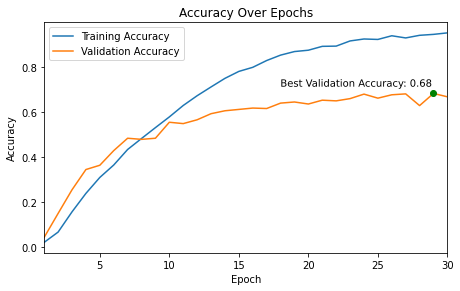

In [63]:
plot_training_history(
    scratch_model_history.history['categorical_accuracy'], 
    scratch_model_history.history['val_categorical_accuracy'], 
    metric_name = 'Accuracy', higher_is_better = True,
    best_label_offset = (-0.1, 0.03),
    save_name = 'scratch_model_accuracy.jpg')

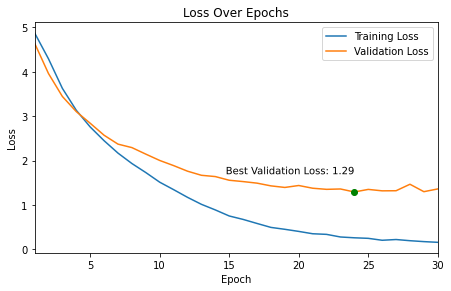

In [57]:
plot_training_history(
    scratch_model_history.history['loss'], 
    scratch_model_history.history['val_loss'], 
    metric_name = 'Loss', higher_is_better = False, 
    best_label_offset = (0, 0.4),
    save_name = 'scratch_model_loss.jpg')

### Transfer Learning

In [18]:
def build_model(application, output_count = 2, input_shape = (*IMAGE_SIZE, 3), 
    dense_count = 128, learning_rate = 1e-04, l2_factor = 1e-05,
    dropout_rate = 0.1):
    '''
    Build a 2D convolutional neural network for transfer learning using a base
    keras application. 

    Args:
        application: Keras application to use as base model.
        output_count: Amount of classes in the model's output.
         - default: 2
        input_shape: Shape of the image data the network will be predicting on.
         - default: (224, 224, 3)
        dense_count: Amount of neurons in the dense layer between the last
        convolutional layer and the output layer.
         - default: 128
        learning_rate: Learning rate for Adam optimizer.
         - default: 1e-5
        l2_factor: Factor for l2 regularizer.
         - default: 1e-2
         dropout_rate: The dropout rate of the last intermediate dense layer.
          - default: 0.2
    Returns:
        model: Convolutional neural network made using provided specifications.
    '''
    # Model property shotrcuts.
    l2 = keras.regularizers.l2(l2_factor)
    adam = keras.optimizers.Adam(learning_rate)
    # Initalize application.
    base_model = application(weights = 'imagenet', include_top = False,
        input_shape = input_shape)
    base_model.trainable = False
    # Initialize model.
    model = keras.models.Sequential()
    # Base
    model.add(base_model)
    # Dense layers
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(dense_count, activation = 'relu', 
        kernel_regularizer = l2, bias_regularizer = l2, 
        activity_regularizer = l2))
    model.add(keras.layers.Dropout(dropout_rate))
    # Output layer
    model.add(keras.layers.Dense(output_count, activation = 'softmax'))
    model.compile(optimizer = adam, loss = 'categorical_crossentropy',
        metrics = [keras.metrics.CategoricalAccuracy()])

    print(model.summary())

    return model

#### VGG16

In [19]:
vgg16_model = build_model(keras.applications.VGG16, output_count = CLASS_COUNT,
    dense_count = 512)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 149)               76437     
Total params: 27,636,693
Trainable params: 12,922,005
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [20]:
# Define callbacks
checkpoint = keras.callbacks.ModelCheckpoint('models/vgg16_model_best', 
    monitor = 'val_categorical_accuracy', mode = 'min', save_freq = 'epoch',
    save_best_only = True, save_weights_only = False)
plateau_handling = keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_categorical_accuracy', patience = 5, factor = 0.1)

vgg16_model_history = vgg16_model.fit(X_train, Y_train, epochs = EPOCHS, 
    validation_data = (X_test, Y_test), batch_size = 40,
    callbacks = [checkpoint, plateau_handling])

Train on 6000 samples, validate on 1000 samples
Epoch 1/30
6000/6000 [==============================] - ETA: 0s - loss: 4.0806 - categorical_accuracy: 0.2172

C:\Programs\Anaconda\envs\pokemon_classifier\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


INFO:tensorflow:Assets written to: models\vgg16_model_best\assets
6000/6000 [==============================] - 57s 9ms/sample - loss: 4.0806 - categorical_accuracy: 0.2172 - val_loss: 2.7989 - val_categorical_accuracy: 0.4960 - lr: 1.0000e-04
Epoch 2/30
6000/6000 [==============================] - 40s 7ms/sample - loss: 1.8256 - categorical_accuracy: 0.7217 - val_loss: 1.6002 - val_categorical_accuracy: 0.7610 - lr: 1.0000e-04
Epoch 3/30
6000/6000 [==============================] - 41s 7ms/sample - loss: 0.8259 - categorical_accuracy: 0.9100 - val_loss: 1.0838 - val_categorical_accuracy: 0.8430 - lr: 1.0000e-04
Epoch 4/30
6000/6000 [==============================] - 41s 7ms/sample - loss: 0.4186 - categorical_accuracy: 0.9742 - val_loss: 0.8751 - val_categorical_accuracy: 0.8690 - lr: 1.0000e-04
Epoch 5/30
6000/6000 [==============================] - 40s 7ms/sample - loss: 0.2399 - categorical_accuracy: 0.9922 - val_loss: 0.7122 - val_categorical_accuracy: 0.9050 - lr: 1.0000e-04
Epoch

In [21]:
print_training_stats(vgg16_model_history)

loss__________________________
     Max: 4.08060
     Min: 0.02365
categorical_accuracy__________
     Max: 1.00000
     Min: 0.21717
val_loss______________________
     Max: 2.79893
     Min: 0.35582
val_categorical_accuracy______
     Max: 0.94000
     Min: 0.49600
lr____________________________
     Max: 0.00010
     Min: 0.00000


In [22]:
len(vgg16_model_history.history['val_categorical_accuracy'])

30

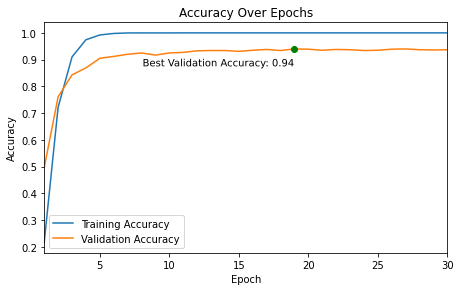

In [23]:
plot_training_history(
    vgg16_model_history.history['categorical_accuracy'], 
    vgg16_model_history.history['val_categorical_accuracy'], 
    metric_name = 'Accuracy', higher_is_better = True,
    best_label_offset = (-0.01, -0.065),
    save_name = 'vgg16_model_accuracy.jpg')

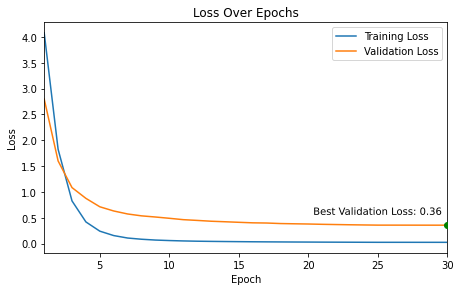

In [52]:
plot_training_history(
    vgg16_model_history.history['loss'], 
    vgg16_model_history.history['val_loss'], 
    metric_name = 'Loss', higher_is_better = False, 
    best_label_offset = (-0.4, 0.2),
    save_name = 'vgg16_model_loss.jpg')

#### Xception

In [25]:
xception_model = build_model(keras.applications.Xception,
    output_count = CLASS_COUNT, dense_count = 512)

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               51380736  
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 149)               76437     
Total params: 72,318,653
Trainable params: 51,457,173
Non-trainable params: 20,861,480
_________________________________________________________________
None


In [26]:
# Define callbacks
checkpoint = keras.callbacks.ModelCheckpoint('models/xception_model_best', 
    monitor = 'val_categorical_accuracy', mode = 'min', save_freq = 'epoch',
    save_best_only = True, save_weights_only = False)
plateau_handling = keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_categorical_accuracy', patience = 5, factor = 0.1)

xception_model_history = xception_model.fit(X_train, Y_train, epochs = EPOCHS, 
    validation_data = (X_test, Y_test),
    callbacks = [checkpoint, plateau_handling])

Train on 6000 samples, validate on 1000 samples
Epoch 1/30
6000/6000 [==============================] - ETA: 0s - loss: 3.3503 - categorical_accuracy: 0.3243

C:\Programs\Anaconda\envs\pokemon_classifier\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


INFO:tensorflow:Assets written to: models\xception_model_best\assets


C:\Programs\Anaconda\envs\pokemon_classifier\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


6000/6000 [==============================] - 77s 13ms/sample - loss: 3.3503 - categorical_accuracy: 0.3243 - val_loss: 1.8226 - val_categorical_accuracy: 0.6210 - lr: 1.0000e-04
Epoch 2/30
6000/6000 [==============================] - 45s 7ms/sample - loss: 0.8417 - categorical_accuracy: 0.8285 - val_loss: 1.0573 - val_categorical_accuracy: 0.7720 - lr: 1.0000e-04
Epoch 3/30
6000/6000 [==============================] - 45s 8ms/sample - loss: 0.2577 - categorical_accuracy: 0.9727 - val_loss: 0.7748 - val_categorical_accuracy: 0.8370 - lr: 1.0000e-04
Epoch 4/30
6000/6000 [==============================] - 45s 8ms/sample - loss: 0.1071 - categorical_accuracy: 0.9960 - val_loss: 0.6451 - val_categorical_accuracy: 0.8550 - lr: 1.0000e-04
Epoch 5/30
6000/6000 [==============================] - 45s 8ms/sample - loss: 0.0719 - categorical_accuracy: 0.9987 - val_loss: 0.6127 - val_categorical_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 6/30
6000/6000 [==============================] - 45s 8ms/sample

In [27]:
print_training_stats(xception_model_history)

loss__________________________
     Max: 3.35028
     Min: 0.01567
categorical_accuracy__________
     Max: 1.00000
     Min: 0.32433
val_loss______________________
     Max: 1.82259
     Min: 0.45313
val_categorical_accuracy______
     Max: 0.91100
     Min: 0.62100
lr____________________________
     Max: 0.00010
     Min: 0.00010


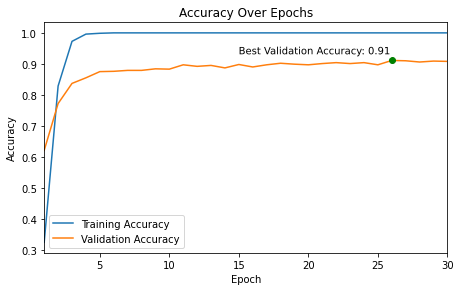

In [44]:
plot_training_history(
    xception_model_history.history['categorical_accuracy'], 
    xception_model_history.history['val_categorical_accuracy'], 
    metric_name = 'Accuracy', higher_is_better = True,
    best_label_offset = (-0.1, 0.02),
    save_name = 'xception_model_accuracy.jpg')

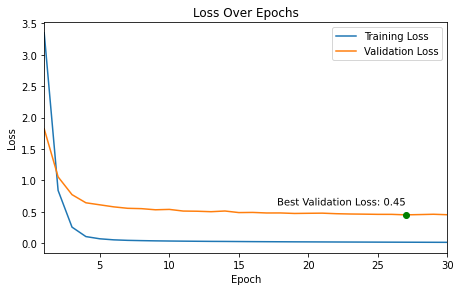

In [51]:
plot_training_history(
    xception_model_history.history['loss'], 
    xception_model_history.history['val_loss'], 
    metric_name = 'Loss', higher_is_better = False,
    best_label_offset = (0, 0.15),
    save_name = 'xception_model_loss.jpg')

### Who's That Pokémon?! Model Showdown

##### Load Assets

In [31]:
scratch_model = keras.models.load_model('Models/scratch_model_best')
vgg16_model = keras.models.load_model('Models/vgg16_model_best')
xception_model = keras.models.load_model('Models/xception_model_best')

In [32]:
def load_images(path, target_size = None):
    """
    Load all images from selected path.
    
    Args:
        path: Directory from which to load all images.
        target_size: size which all images should be resized to. If none is
        provided all images remain their original size.
         - default: None
    Returns:
        images: List of every image in the target directory as numpy arrays.
    """
    # Initialize images list.
    images = []
    
    for image_name in os.listdir(path):
        # Get image from specified path.
        image = PIL.Image.open(path + '/' + image_name)
        # Optionally resize image.
        if target_size != None:
            image = image.resize(target_size)
        
        image = np.array(image)
        
        images.append(image)
    
    return images
        

In [33]:
# Grab images for the who's that pokemon.
colors = load_images(PKMN_DIRECTORY + '/Sprites Color', 
    target_size = IMAGE_SIZE)
silhouettes = load_images(PKMN_DIRECTORY + '/Sprites Silhouette', 
    target_size = IMAGE_SIZE)

##### Make Predictions

In [34]:
def get_prediction(model, image):
    """
    Predict on an image using the provided model and find the name of the
    pokemon which correspondes to that prediction.
    
    Args:
        model: The model used to predict on the provided image. Output of the
        model must match the amount of classes in the training data directory.
        image: The image that the provided model should predict on.
    """
    # Get the names of every pokemon from the train data directory.
    pokemon_names = np.array(os.listdir(PKMN_DIRECTORY + '/Train'))
    # Make image compatible with input shape of model.
    model_input = np.array([image])
    
    pred = model.predict(model_input)[0]
    # Use the position of the highest value in the prediction to select a name.
    bool_pred = [pred == max(pred)]
    pred_pokemon_name = pokemon_names[bool_pred][0]
    
    return pred_pokemon_name

In [35]:
silhouette_predictions = []
color_predictions = []

for color, silhouette in zip(colors, silhouettes):
    # Normalize inputs.
    normalized_silhouette = silhouette.astype('float') / 255
    normalized_color = color.astype('float') / 255
    # Get predictions from each model.
    models = [scratch_model, vgg16_model, xception_model]
    silhouette_prediction = [get_prediction(model,  normalized_silhouette) 
                             for model in models]
    color_prediction = [get_prediction(model,  normalized_color) 
                        for model in models]
    # Record predictions from each model.
    pred_template = 'Scratch Model: {}' + '\n' + \
                    'VGG16: {}' + '\n' + \
                    'Xception: {}'
    silhouette_predictions.append(pred_template.format(*silhouette_prediction))
    color_predictions.append(pred_template.format(*color_prediction))

C:\Programs\Anaconda\envs\pokemon_classifier\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
C:\Users\linkw\AppData\Local\Temp/ipykernel_20232/942208791.py:19: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pred_pokemon_name = pokemon_names[bool_pred][0]


##### Silhouettes

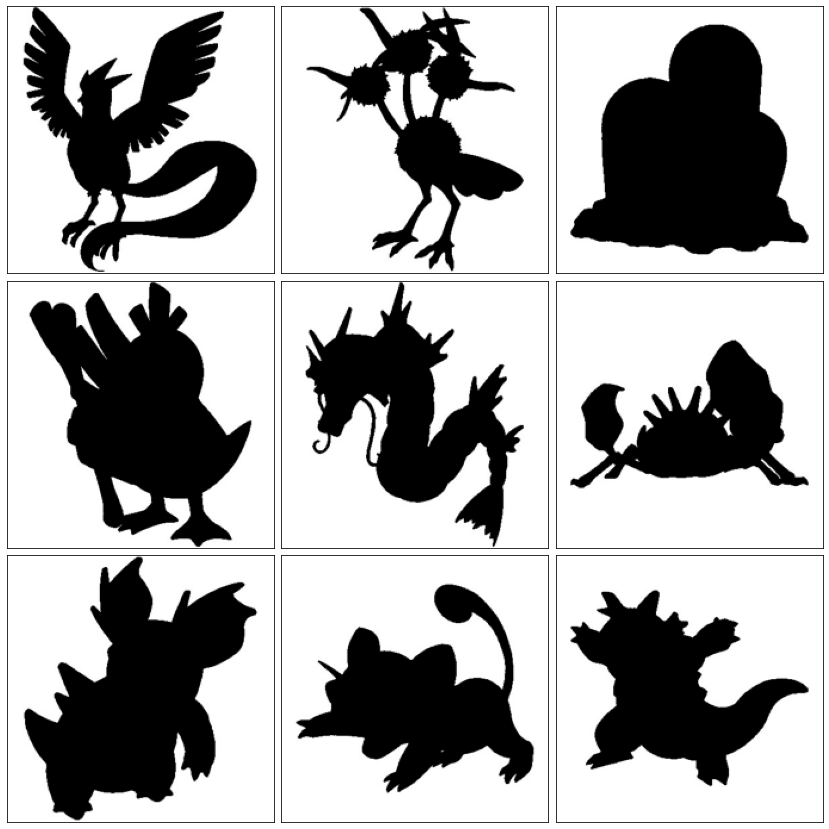

In [36]:
# Initialize plot.
fig = plt.figure(1, (15, 15))
grid = ImageGrid(fig, 111, nrows_ncols = (3, 3), axes_pad = 0.1)

predictions = []

for ax, image in zip(grid, silhouettes):
    # Show image in grid cell.
    ax.imshow(image)
    # Remove ticks from around image.
    ax.tick_params(axis = 'both', which = 'both', bottom = False, left = False,
        labelbottom = False, labelleft = False)

fig.savefig(PLOT_DIRECTORY + '/Silhouettes.jpg', bbox_inches = 'tight')

##### Silhouette Predictions

In [40]:
def generate_prediction_image(predictions, save_name = None):
    """
    Generate a 3x3 grid of images and label them with the provided predictions.
    
    Args:
        predictions: Iterable of strings, each describing a prediction for each
        image.
        save_name: Name to save the generated image under. If None, image will
        not be saved.
         - default: None
    """
    # Initialize plot.
    fig = plt.figure(1, (15, 15))
    grid = ImageGrid(fig, 111, nrows_ncols = (3, 3), axes_pad = 0.1)

    for ax, prediction, image, image_name in zip(grid, predictions, colors,
        os.listdir(PKMN_DIRECTORY + '/Sprites Color')):
        # Show image in grid cell.
        ax.imshow(image)
        # Remove ticks from around image.
        ax.tick_params(axis = 'both', which = 'both', bottom = False, 
            left = False, labelbottom = False, labelleft = False)
        # Attach pokemon name to image.
        pkmn_name = ax.text(122, 20, image_name[:-4], ha = 'center', 
            fontdict = {'fontsize': 18, 'fontweight': 1000})
        pkmn_name.set_path_effects([pe.withStroke(linewidth = 4, foreground = 'w')])
        # Attach predictions to image.
        title = ax.set_title(prediction, y = 0, loc = 'center',
            fontdict = {'fontsize': 18, 'fontweight': 1000})
        title.set_path_effects([pe.withStroke(linewidth = 4, foreground = 'w')])

    if save_name != None:
        fig.savefig(PLOT_DIRECTORY + '/' + save_name, bbox_inches = 'tight')

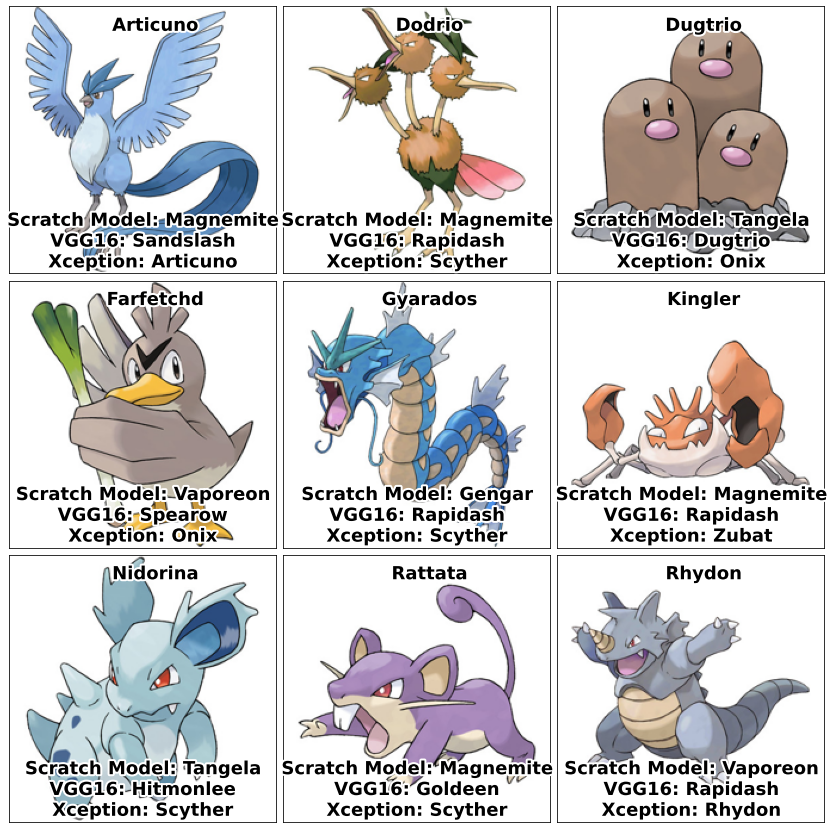

In [41]:
generate_prediction_image(silhouette_predictions, save_name = 'silhouette_predictions.jpg')

##### Color Predictions

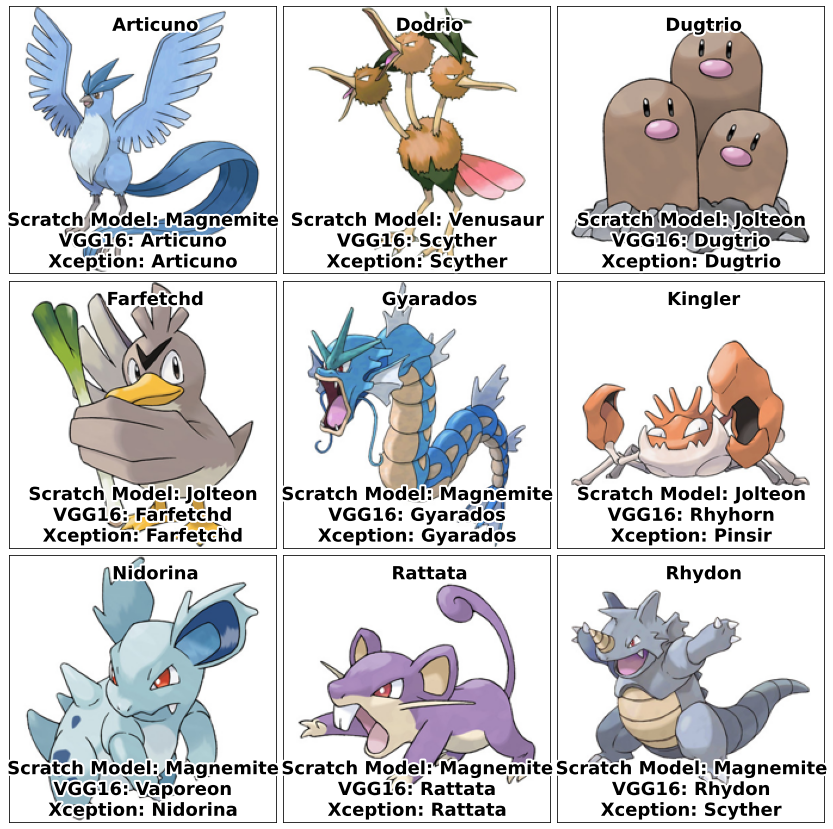

In [42]:
generate_prediction_image(color_predictions, save_name = 'color_predictions.jpg')